In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

# Load the datasets
data_2022 = pd.read_csv('Climate_2022.csv')
data_2023 = pd.read_csv('Climate_2023.csv')
data_2024 = pd.read_csv('Climate_2024.csv')

# Adding a 'Year' column
data_2022['Year'] = 2022
data_2023['Year'] = 2023
data_2024['Year'] = 2024

# Combine the datasets
combined_data = pd.concat([data_2022, data_2023, data_2024], ignore_index=True)
combined_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.63,43.68,TORONTO INTL A,6158731,2022-01-01,2022,1,1,NaN,4.5,...,2.8,NaN,2.4,NaN,3.0,E,35.0,NaN,46.0,NaN
1,-79.63,43.68,TORONTO INTL A,6158731,2022-01-02,2022,1,2,NaN,-2.9,...,2.6,NaN,1.4,NaN,3.0,NaN,36.0,NaN,52.0,NaN
2,-79.63,43.68,TORONTO INTL A,6158731,2022-01-03,2022,1,3,NaN,-6.6,...,0.0,NaN,0.0,NaN,5.0,NaN,NaN,M,NaN,M
3,-79.63,43.68,TORONTO INTL A,6158731,2022-01-04,2022,1,4,NaN,2.5,...,0.0,NaN,0.0,NaN,NaN,NaN,24.0,NaN,33.0,NaN
4,-79.63,43.68,TORONTO INTL A,6158731,2022-01-05,2022,1,5,NaN,4.1,...,0.0,T,0.8,NaN,1.0,NaN,23.0,NaN,68.0,NaN


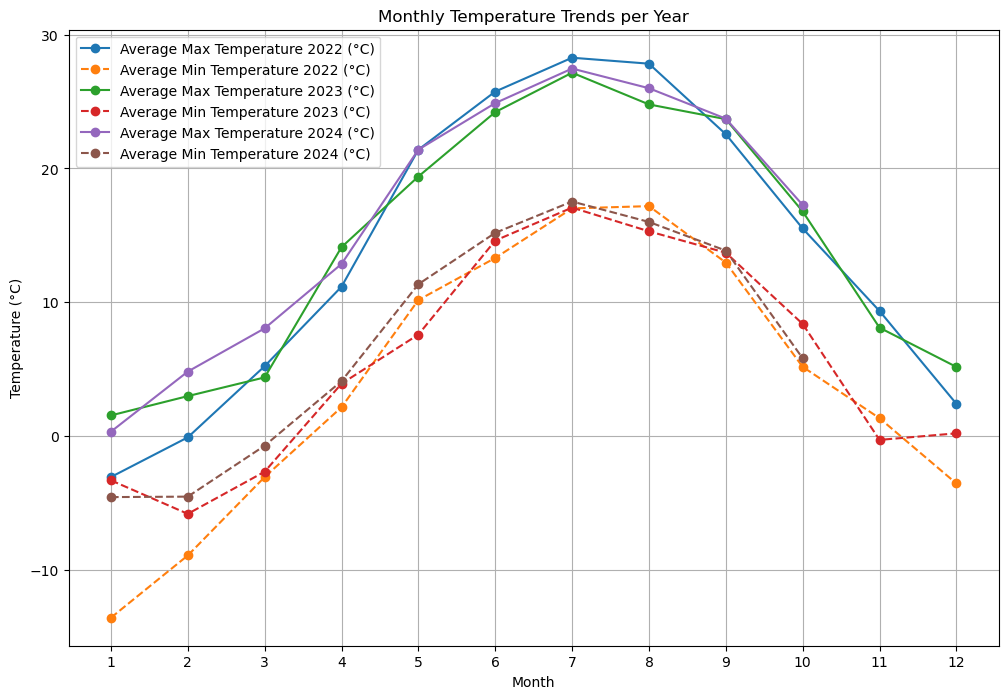

In [2]:
# Grouping data by Year and Month and calculating the mean of Max Temp (°C) and Min Temp (°C) for each month per year
monthly_temperature_trends = combined_data.groupby(['Year', 'Month'])[['Max Temp (°C)', 'Min Temp (°C)']].mean().reset_index()

# Plotting the monthly temperature trends for each year
plt.figure(figsize=(12, 8))

for year in monthly_temperature_trends['Year'].unique():
    subset = monthly_temperature_trends[monthly_temperature_trends['Year'] == year]
    plt.plot(subset['Month'], subset['Max Temp (°C)'], marker='o', label=f'Average Max Temperature {year} (°C)')
    plt.plot(subset['Month'], subset['Min Temp (°C)'], marker='o', linestyle='--', label=f'Average Min Temperature {year} (°C)')

plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperature Trends per Year')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Load the Sewer Outfalls dataset to examine its structure and contents
sewer_outfalls = pd.read_csv('Sewer Outfalls - 4326.csv')

# Display the first few rows of the sewer outfalls data to understand its structure
sewer_outfalls.head()

,_id,Asset Identification,Sewer Outfall Flow Type,geometry
0,1,OF4404598966,Storm,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.57..."
1,2,OF3431802624,Storm,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.52..."
2,3,OF5283424884,Storm,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.25..."
3,4,OF5041420179,Storm,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.30..."
4,5,OF4602625526,Storm,"{""type"": ""MultiPoint"", ""coordinates"": [[-79.24..."


In [7]:
import json

# Extracting coordinates from the geometry column in the sewer outfalls dataset
# Assuming the geometry column is in GeoJSON format, we will parse it to obtain latitude and longitude
sewer_outfalls['Longitude'] = sewer_outfalls['geometry'].apply(lambda x: json.loads(x)['coordinates'][0][0])
sewer_outfalls['Latitude'] = sewer_outfalls['geometry'].apply(lambda x: json.loads(x)['coordinates'][0][1])

# Display the updated sewer outfalls data with extracted Longitude and Latitude for mapping
sewer_outfalls[['Asset Identification', 'Sewer Outfall Flow Type', 'Longitude', 'Latitude']].head()

,Asset Identification,Sewer Outfall Flow Type,Longitude,Latitude
0,OF4404598966,Storm,-79.572228,43.738338
1,OF3431802624,Storm,-79.526774,43.650804
2,OF5283424884,Storm,-79.250177,43.817227
3,OF5041420179,Storm,-79.308697,43.795526
4,OF4602625526,Storm,-79.242420,43.755827


In [9]:
from scipy.spatial import cKDTree

# Extracting coordinates from climate data to prepare for nearest neighbor matching
climate_coords = combined_data[['Longitude (x)', 'Latitude (y)']].dropna().values
outfall_coords = sewer_outfalls[['Longitude', 'Latitude']].values

# Building a KDTree for fast nearest-neighbor lookup
climate_tree = cKDTree(climate_coords)

# Finding the nearest climate data point for each outfall
distances, indices = climate_tree.query(outfall_coords)

# Adding the matched climate data for each outfall based on nearest climate location
# Using indices from the climate data (combined_data) for relevant climate attributes
nearest_climate_data = combined_data.iloc[indices].reset_index(drop=True)
outfall_climate_combined = pd.concat([sewer_outfalls.reset_index(drop=True), nearest_climate_data], axis=1)

# Display the first few rows of the resulting dataset with outfall and nearest climate data combined
outfall_climate_combined[['Asset Identification', 'Sewer Outfall Flow Type', 'Longitude', 'Latitude',
                          'Date/Time', 'Max Temp (°C)', 'Min Temp (°C)', 'Total Precip (mm)', 'Year']].head()


,Asset Identification,Sewer Outfall Flow Type,Longitude,Latitude,Date/Time,Max Temp (°C),Min Temp (°C),Total Precip (mm),Year
0,OF4404598966,Storm,-79.572228,43.738338,2022-01-01,4.5,-3.2,2.4,2022
1,OF3431802624,Storm,-79.526774,43.650804,2022-01-01,4.5,-3.2,2.4,2022
2,OF5283424884,Storm,-79.250177,43.817227,2022-01-01,4.5,-3.2,2.4,2022
3,OF5041420179,Storm,-79.308697,43.795526,2022-01-01,4.5,-3.2,2.4,2022
4,OF4602625526,Storm,-79.242420,43.755827,2022-01-01,4.5,-3.2,2.4,2022


In [13]:
# Calculating the average precipitation near each outfall
average_precipitation_outfall = outfall_climate_combined.groupby('Asset Identification')['Total Precip (mm)'].mean().reset_index()

# Renaming the column for clarity
average_precipitation_outfall.rename(columns={'Total Precip (mm)': 'Average Precipitation (mm)'}, inplace=True)

# Displaying the results
average_precipitation_outfall.head()

,Asset Identification,Average Precipitation (mm)
0,OF1001,2.4
1,OF200000,2.4
2,OF200001,2.4
3,OF200002,2.4
4,OF200003,2.4


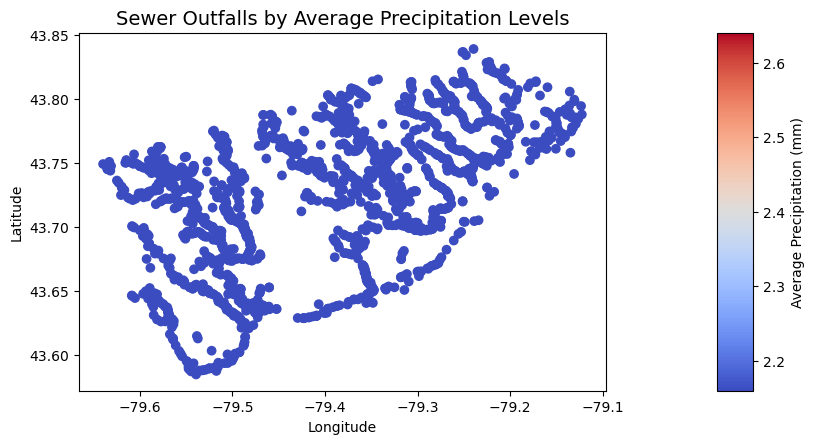

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Convert the outfall data to a GeoDataFrame
sewer_outfalls_gdf = gpd.GeoDataFrame(
    average_precipitation_outfall.merge(sewer_outfalls, on='Asset Identification'),
    geometry=gpd.points_from_xy(sewer_outfalls['Longitude'], sewer_outfalls['Latitude']),
    crs="EPSG:4326"
)

# Plotting the map of sewer outfalls, color-coded by average precipitation
fig, ax = plt.subplots(figsize=(10, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot each outfall point with color representing the average precipitation level
sewer_outfalls_gdf.plot(
    ax=ax, column='Average Precipitation (mm)', cmap='coolwarm', legend=True, cax=cax,
    legend_kwds={'label': "Average Precipitation (mm)", 'orientation': "vertical"}
)

# Adding map details
ax.set_title("Sewer Outfalls by Average Precipitation Levels", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()